# Medium Stats Data Analysis

In the previous notebook, we worked on scraping and cleaning the data from Mediums stats page by leveraging `Selenium` and `BeautifulSoup`. Now that we have our data looking good, we've finally made it to the fun part. Enter exploratory data analysis. This is going to be the meat of this project where we'll dive into the more subtle aspects of analyzing engagement in respect to my work and later on a larger scale. This notebook directly corresponds to the Medium post linked below.

In [6]:
# Imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette('coolwarm')

In [7]:
# Read data
df = pd.read_csv('mystats.csv')

In [8]:
# Remove newsletter bias and reset index
df = df[~df['Title'].str.contains('Self Driven Data Science')]
df.reset_index(inplace=True, drop=True)
df.head()

,Title,Publication,Read Time,Views,Reads,Read Ratio,Fans
0,An Ode to the Type A Data Scientist,Towards Data Science,7,3224,699,21.681141,72
1,Choosing Your First Job: Size Matters,Hacker Noon,7,391,144,36.828645,19
2,Python for Data Science and Machine Learning B...,Towards Data Science,6,2175,795,36.551724,48
3,The Key to Optimal Internships,Hacker Noon,5,197,80,40.609137,9
4,9 Essential Newsletters for Data Scientists,Towards Data Science,5,5401,1216,22.514349,59


## Exploratory Data Analysis
This section will largely be free form; a combination of analyzing metrics and visualizations before diving deeper down interesting rabbit holes and examining possible relationships and statistics further. With that being said, here's an initial list of some questions that I wanted to further pursue:
* General overview of top performers from different metrics
* Distribution of views, reads, fans, etc
* Feature engineering new metrics ex. read-fan ratio
* Relationship between length of article and different engagement metrics
* Average claps and other engagement metrics by segments like publication

### Getting Started with an Overview

Let's get started by looking at which of my posts have performed the best in different categories as well as some high level numerical stats too. We'll use these simple plots and stats as a jumping off point for more interesting analysis later in the notebook.

In [9]:
# General overview
df.describe()

,Read Time,Views,Reads,Read Ratio,Fans
count,29.000000,29.000000,29.000000,29.000000,29.000000
mean,6.000000,6668.827586,1417.862069,35.919137,136.068966
std,1.908627,18470.585968,3651.076971,13.979027,356.633458
min,4.000000,109.000000,60.000000,10.426731,3.000000
25%,5.000000,391.000000,140.000000,26.635656,10.000000
50%,6.000000,967.000000,334.000000,36.828645,29.000000
75%,7.000000,2484.000000,789.000000,42.553191,51.000000
max,13.000000,85373.000000,14945.000000,63.893511,1447.000000


There's a couple things that I found interesting here. First of all, after removing the posts associated with my weekly data science newsletter, I've published 29 stories here on Medium. Certainly not an ideal sample size, but for our purposes - not bad! 

I can see that on average, my posts are 6 minutes long and gather about 6,500 views with around 1,300 reads. This leads to an average read ratio of ~35% and roughly 132 fans per post. I suspect these numbers are heavily skewed due to the success of a couple posts in particular, which would pull the mean up considerably, but let's look into that more later.

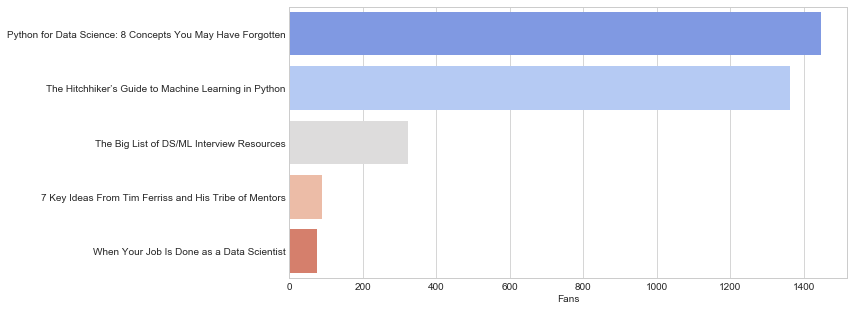

In [10]:
# Top 5 performers by Fans
plt.figure(figsize=(10,5))
temp = df.sort_values(by='Fans', ascending=False).head()
g = sns.barplot('Fans', 'Title', data=temp, palette='coolwarm');
plt.ylabel('');

You can see here that even within my top 5 posts of all time (ranking by `Fans`), there is a huge descrepency between my top two posts and the next few. Note that there is also some bias here since Medium switched to the 'clap' feature after a couple of my earlier posts had already gone out. I've found that users are more likely to 'clap' than they were previously to 'like' a post. Just a hunch though. 

I'd imagine this is a common theme out there. Not every post that you put out will be a homerun, you are always going to have a couple that outperform the rest. If you're interested, here's the link to each post below:
* https://towardsdatascience.com/python-for-data-science-8-concepts-you-may-have-forgotten-i-did-825966908393
* https://medium.freecodecamp.org/the-hitchhikers-guide-to-machine-learning-algorithms-in-python-bfad66adb378

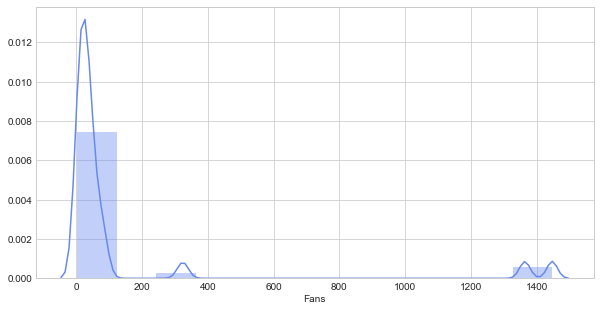

In [16]:
# Distribution of Fans per post
plt.figure(figsize=(10,5))
sns.distplot(df['Fans'], bins=12);

This confirms our thoughts about the top two posts significantly outperforming the others from a `Fans` perspective. We see that my top two performing posts alone make up over 70% of my total views, even with ~30 stories. Next we'll go into whether or not this is really a reliable metric and brainstorm possible other metrics that we can produce as a result of feature engineering.  

## Feature Engineering and Metrics

In this section, I'll go into more detail on each specific metric while analyzing the pros and cons along with what it is trying to tell us. This includes engineering new features and discussing them along with exploring relationships between other features.

Initial ideas: fans/read ratio, adjusted reads for read time, weighted average of reads/views and fans/reads

### Reads/Views Ratio
This metric has already found it's home on the current Medium stats dashboard, but let's look into a bit deeper. What exactly does this tell us? In a nutshell, this is trying to communicate how effective a post was at turning views into reads. It tells us how engaging a post is. This is probably the most valuable metric given to us at the moment, as it actually tells us something about how a post was percieved, contrary to counting vanity metrics.

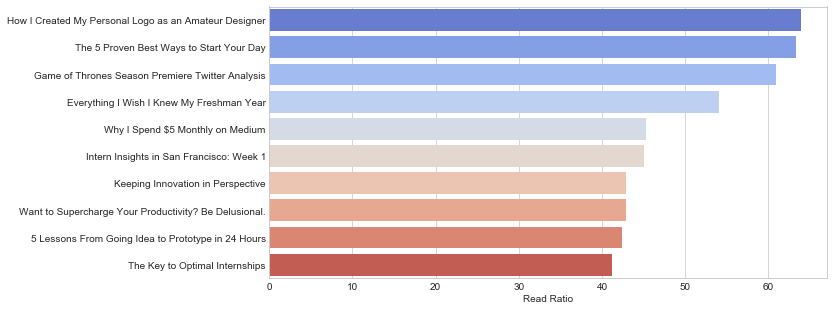

In [12]:
# Top read ratios
plt.figure(figsize=(10,5))
temp = df.sort_values(by='Read Ratio', ascending=False).head(10)
g = sns.barplot('Read Ratio', 'Title', data=temp, palette='coolwarm');
plt.ylabel('');

This is super interesting. My very first Medium post ever has the highest read ratio. Looking at these posts, I remember these all being somewhat short, mostly under 6 minutes or so. I also remember these all having plenty of pictures and bolded headers or lists for easy skimming which I'm guessing plays a big part as well. Let's follow that initial hunch and check out the relationship between read time and read ratio to check for any bias there.

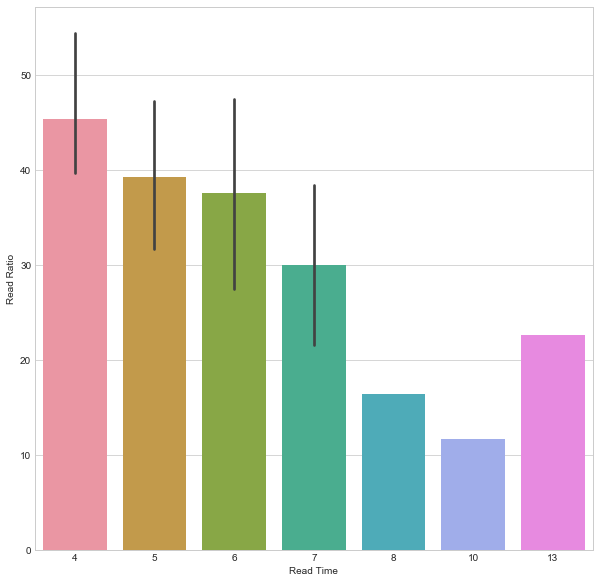

In [60]:
# Read time vs. read ratio
plt.figure(figsize=(10,10))
sns.barplot(x='Read Time', y='Read Ratio', data=df);

There appears to be a clear trend here. The shorter the post, the more likely a reader is to read it. This is intuitive, but nice to see that the data backs it up. What would be interesting to check out here is if longer posts are more likely to convert to fans? This would create a trade-off between engagement and value proposition. Which leads us to our next point...

### Fans/Reads Ratio

We already looks at the more traditional `Read Ratio` metric above that you've probably already seen on the dashboard. I believe that it doesn't tell the whole picture however. By `Read Ratio` alone, you are simply seeing how engaging your post is, not necessarily how valuable it is to your readers, or how much they enjoyed it. You can litter buzzwords and infographics throughout your post, but chances are that readers didn't find it particularly special. 

So how do we judge how much readers enjoyed your post using what we have? With the data I have, I suggest `Fans Ratio`. This is simply calculated with `Fans/Reads` and I believe it will much more effectively describe how well recieved a given post is.

In [17]:
# Create feature
df['Fan Ratio'] = (df['Fans'] / df['Views']) * 100
df.sort_values('Fan Ratio', ascending=False).head()

,Title,Publication,Read Time,Views,Reads,Read Ratio,Fans,Fan Ratio
25,The 5 Proven Best Ways to Start Your Day,The Ascent,4,109,69,63.302752,10,9.174312
22,Everything I Wish I Knew My Freshman Year,The Ascent,6,112,60,53.571429,9,8.035714
5,Stop Cheating Yourself out of Great Ideas,The Startup,6,394,140,35.532995,27,6.852792
9,Why I Spend $5 Monthly on Medium,The Startup,5,536,243,45.335821,31,5.783582
17,Want to Supercharge Your Productivity? Be Delu...,The Startup,4,177,76,42.937853,9,5.084746


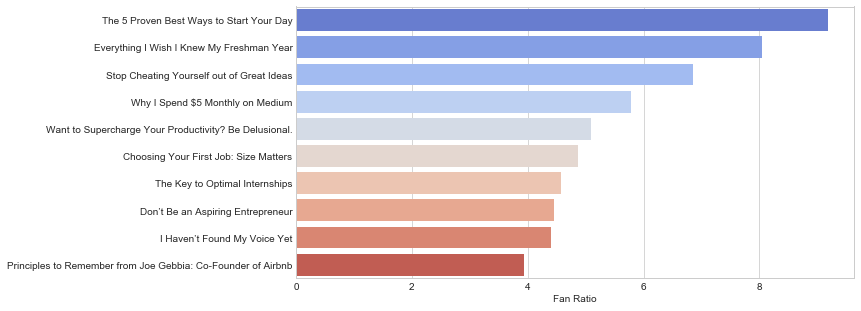

In [18]:
# Visualization
plt.figure(figsize=(10,5))
temp = df.sort_values(by='Fan Ratio', ascending=False).head(10)
g = sns.barplot('Fan Ratio', 'Title', data=temp, palette='coolwarm');
plt.ylabel('');

It appears my posts on self improvement garnered a far better `Fan Ratio` than my technical data science posts. I'm really curious if this is simply a built in bias dealing with the genre of post or not. Luckily, all my posts are published based on their goals. Startup is business, entrepreneurship, and self improvement. Ascent is all self improvement. Hackernoon and Towards Data Science and Freecodecamp are generally are technical, though some posts differ. Could also be that some publications just have generally more active readers. Or a small sample size. Hard to tell, but let's look into it.

In [19]:
# Group by publication
temp = df.groupby('Publication').mean()['Fan Ratio']
temp = temp.sort_values(ascending=False)
print(temp)

Publication
The Ascent              8.605013
The Startup             3.985051
Hacker Noon             3.608070
Towards Data Science    2.440604
UX Planet               1.711613
freeCodeCamp            1.597695
Name: Fan Ratio, dtype: float64


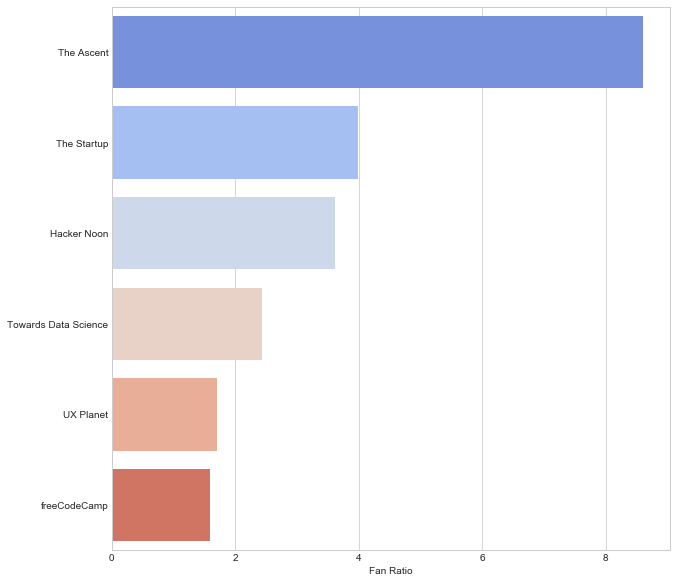

In [20]:
# Visualize publications effect on Fan Ratio
plt.figure(figsize=(10,10))
sns.barplot(x=temp, y=temp.index);
plt.ylabel('');

Grouping my publication reconfirms this thought. Honestly, my best guess is that self improvement posts get more claps in general. I mean they absolutely kill it on Medium through and through. Let's examine that trade-off we talked about earlier and check out the relationship between  `Fan Ratio` and `Read Ratio`.

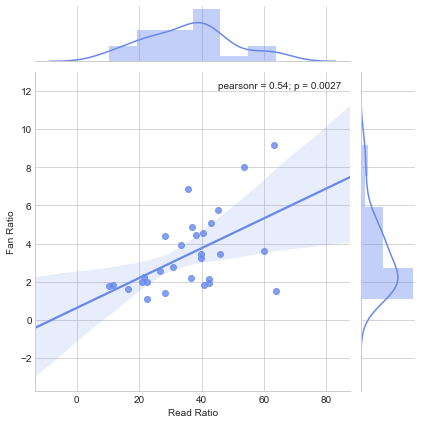

In [21]:
# Fan Ratio vs. Read Ratio
plt.figure(figsize=(10,5));
sns.jointplot('Read Ratio', 'Fan Ratio', df, kind='reg_fit');

With a nearly 0.6 pearson correlation, there's some strong evidence to suggest a relationship between `Read Ratio` and `Fan Ratio`. This is exciting stuff and makes a lot of sense intuitively. Better posts are not only engaging, but also enjoyable for the reader and more likely to receive applause.

## Wrapping Up

I hope this was informative for anyone reading. I know I learned a lot. It's worth noting that this type of analysis should be available to all writers, not just those that are data science practioners. Data analysis should be democratized for writers and content creators. Even with my ~30 post sample size, I was able to walk away with some interesting insights:
* 2 out of my 30+ posts make up over 70% of my total lifetime views
* `Read Ratio` and `Read Time` appear to be strongly correlated
* Publication choice matters for enjoyment stats like Fan Ratio
* `Read Ratio` and `Fan Ratio` correlated - strong posts do both well

Note that this analysis is just from using the fraction of data available to users on the Medium Stats page. Imagine if we had more of our data and information at our disposal; if writers were empowered to use Medium Stats for improving their work and understanding how readers perceive it rather than boosting their ego with simple vanity stats. It's no small task, but I believe it can be done.

Hope you enjoyed this project, I know I did. Once again, reiterating that I am in no way affiliated with or working for Medium. However, you can follow my writing at the link below if interested. Thanks for reading!

https://medium.com/@conordewey3